In [13]:
# IMPORTS
import pandas as pd
import numpy as np
import time
import os
import warnings
import joblib
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
from mlflow.tracking import MlflowClient

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score

from gensim.models import Word2Vec

warnings.filterwarnings('ignore')


In [14]:
# Config MLFlow
os.makedirs('../mlruns', exist_ok=True)
os.makedirs('../mlruns/.trash', exist_ok=True)
mlflow.set_tracking_uri("file:///C:/Users/lza/Documents/P05_Projet_tags_StackOverflow/mlruns")
EXPERIMENT_NAME = "Approche_Supervisee_Features"
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='file:///C:/Users/lza/Documents/P05_Projet_tags_StackOverflow/mlruns/854480619331714838', creation_time=1767957209739, experiment_id='854480619331714838', last_update_time=1767957209739, lifecycle_stage='active', name='Approche_Supervisee_Features', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [15]:
# Chargement données
df_train = pd.read_csv('../data/processed/df_preprocessed.csv')
mlb = joblib.load('../data/processed/mlb.pkl')
print(f"Dataset: {len(df_train)} questions, {len(mlb.classes_)} tags")

Dataset: 50000 questions, 396 tags


In [16]:
# Préparation Y
def extract_tags(tags_str):
    if not isinstance(tags_str, str): return []
    return [tag.strip() for tag in tags_str.strip('<>').split('><') if tag.strip()]

df_train['Tags_List'] = df_train['Tags'].apply(extract_tags)
df_train['Tags_Filtered'] = df_train['Tags_List'].apply(
    lambda tags: [tag for tag in tags if tag in set(mlb.classes_)])
Y_labels = mlb.transform(df_train['Tags_Filtered'])

# Filtrage et split
X = df_train['Tokens_LDA']
mask = df_train['Tags_Filtered'].apply(lambda x: len(x) > 0)
X, Y = X[mask], Y_labels[mask]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 37565, Test: 9392


In [17]:
# Métrique TCTP (Tag Coverage Top-K)
def coverage_rate_top_k(Y_true, Y_probas, mlb, k=5):
    top_k_indices = np.argsort(Y_probas, axis=1)[:, -k:]
    total_coverage, total_samples = 0, 0
    for i in range(Y_true.shape[0]):
        true_idx = np.where(Y_true[i] == 1)[0]
        if len(true_idx) > 0:
            covered = len(set(true_idx).intersection(set(top_k_indices[i])))
            total_coverage += covered / len(true_idx)
            total_samples += 1
    return total_coverage / total_samples if total_samples > 0 else 0.0

## Modèle 1 : TF-IDF

In [30]:
# TF-IDF Vectorisation
vectorizer = TfidfVectorizer(max_features=20000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print(f"TF-IDF: {X_train_tfidf.shape}")

TF-IDF: (37565, 20000)


In [31]:
# Training TF-IDF
with mlflow.start_run(run_name="TF-IDF_LogReg"):
    mlflow.log_params({"feature_type": "TF-IDF", "max_features": 20000, "C": 0.1})
    
    clf = OneVsRestClassifier(LogisticRegression(C=0.1, solver='liblinear', random_state=42))
    start = time.time()
    clf.fit(X_train_tfidf, Y_train)
    fit_time = time.time() - start
    
    Y_pred = clf.predict(X_test_tfidf)
    Y_proba = clf.predict_proba(X_test_tfidf)
    
    f1 = f1_score(Y_test, Y_pred, average='micro')
    jaccard = jaccard_score(Y_test, Y_pred, average='samples')
    tctp = coverage_rate_top_k(Y_test, Y_proba, mlb, k=5)
    
    mlflow.log_metrics({"f1_micro": f1, "jaccard_samples": jaccard, "tctp_top_5": tctp, "fit_time_sec": fit_time})
    print(f"TF-IDF | F1: {f1:.4f} | Jaccard: {jaccard:.4f} | TCTP: {tctp:.4f} | Time: {fit_time:.1f}s")

TF-IDF | F1: 0.1066 | Jaccard: 0.0638 | TCTP: 0.5055 | Time: 90.9s


## Modèle 2 : Word2Vec

In [18]:
# Word2Vec Training
VECTOR_SIZE = 100
X_train_tokens = X_train.apply(str.split).tolist()
X_test_tokens = X_test.apply(str.split).tolist()

w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=VECTOR_SIZE, window=5, min_count=5, sg=0, workers=4)
w2v_model.train(X_train_tokens, total_examples=len(X_train_tokens), epochs=10)
print(f"Word2Vec trained: {VECTOR_SIZE} dimensions")


Word2Vec trained: 100 dimensions


In [20]:
# Document vectorisation
def doc_vector(model, tokens):
    words = [w for w in tokens if w in model.wv]
    if not words: return np.zeros(model.vector_size)
    return np.mean(model.wv[words], axis=0)

X_train_w2v = np.array([doc_vector(w2v_model, t) for t in X_train_tokens])
X_test_w2v = np.array([doc_vector(w2v_model, t) for t in X_test_tokens])
print(f"Word2Vec features: {X_train_w2v.shape}")

Word2Vec features: (37565, 100)


In [21]:
# Training Word2Vec
with mlflow.start_run(run_name="Word2Vec_LogReg"):
    mlflow.log_params({"feature_type": "Word2Vec_Mean", "vector_size": VECTOR_SIZE, "C": 0.1})
    
    clf_w2v = OneVsRestClassifier(LogisticRegression(C=0.1, solver='liblinear', random_state=42))
    start = time.time()
    clf_w2v.fit(X_train_w2v, Y_train)
    fit_time = time.time() - start
    
    Y_pred_w2v = clf_w2v.predict(X_test_w2v)
    Y_proba_w2v = clf_w2v.predict_proba(X_test_w2v)
    
    f1 = f1_score(Y_test, Y_pred_w2v, average='micro')
    jaccard = jaccard_score(Y_test, Y_pred_w2v, average='samples')
    tctp = coverage_rate_top_k(Y_test, Y_proba_w2v, mlb, k=5)
    
    mlflow.log_metrics({"f1_micro": f1, "jaccard_samples": jaccard, "tctp_top_5": tctp, "fit_time_sec": fit_time})
    input_example = X_train_w2v[:1] 
    mlflow.sklearn.log_model(
        clf_w2v,
        name="w2v_classifier",  
        registered_model_name="Word2Vec_LogReg",
        input_example=input_example
    )
    print(f"Word2Vec | F1: {f1:.4f} | Jaccard: {jaccard:.4f} | TCTP: {tctp:.4f} | Time: {fit_time:.1f}s")

Word2Vec | F1: 0.3064 | Jaccard: 0.1973 | TCTP: 0.6538 | Time: 298.8s


Registered model 'Word2Vec_LogReg' already exists. Creating a new version of this model...
Created version '2' of model 'Word2Vec_LogReg'.


## Modèle 3 : BERT (embeddings pré-calculés)

In [ ]:
# Charger embeddings BERT pré-calculés
BERT_DIR = '../data/bert_embeddings'
if os.path.exists(f"{BERT_DIR}/X_train_bert.npy"):
    X_train_bert = np.load(f"{BERT_DIR}/X_train_bert.npy")
    X_test_bert = np.load(f"{BERT_DIR}/X_test_bert.npy")
    print(f"BERT loaded: {X_train_bert.shape}")
else:
    print(" BERT embeddings not found. Run extraction first.")

BERT loaded: (37565, 768)


In [36]:
# Training BERT
if 'X_train_bert' in dir():
    with mlflow.start_run(run_name="BERT_LogReg"):
        mlflow.log_params({"feature_type": "BERT", "C": 0.1})
        
        clf_bert = OneVsRestClassifier(LogisticRegression(C=0.1, solver='saga', random_state=42), n_jobs=-1)
        start = time.time()
        clf_bert.fit(X_train_bert, Y_train)
        fit_time = time.time() - start
        
        Y_pred_bert = clf_bert.predict(X_test_bert)
        Y_proba_bert = clf_bert.predict_proba(X_test_bert)
        
        f1 = f1_score(Y_test, Y_pred_bert, average='micro')
        jaccard = jaccard_score(Y_test, Y_pred_bert, average='samples')
        tctp = coverage_rate_top_k(Y_test, Y_proba_bert, mlb, k=5)
        
        mlflow.log_metrics({"f1_micro": f1, "jaccard_samples": jaccard, "tctp_top_5": tctp, "fit_time_sec": fit_time})
        print(f"BERT | F1: {f1:.4f} | Jaccard: {jaccard:.4f} | TCTP: {tctp:.4f} | Time: {fit_time:.1f}s")

BERT | F1: 0.2601 | Jaccard: 0.1689 | TCTP: 0.5798 | Time: 3905.2s


## Modèle 4 : USE (Universal Sentence Encoder)

In [ ]:
# Charger embeddings USE pré-calculés
USE_DIR = '../data/use_embeddings'
if os.path.exists(f"{USE_DIR}/X_train_use.npy"):
    X_train_use = np.load(f"{USE_DIR}/X_train_use.npy")
    X_test_use = np.load(f"{USE_DIR}/X_test_use.npy")
    print(f"USE loaded: {X_train_use.shape}")
else:
    print(" USE embeddings not found.")

USE loaded: (37565, 512)


In [38]:
# Training USE
if 'X_train_use' in dir():
    with mlflow.start_run(run_name="USE_LogReg"):
        mlflow.log_params({"feature_type": "USE", "C": 0.1})
        
        clf_use = OneVsRestClassifier(LogisticRegression(C=0.1, solver='saga', random_state=42), n_jobs=-1)
        start = time.time()
        clf_use.fit(X_train_use, Y_train)
        fit_time = time.time() - start
        
        Y_pred_use = clf_use.predict(X_test_use)
        Y_proba_use = clf_use.predict_proba(X_test_use)
        
        f1 = f1_score(Y_test, Y_pred_use, average='micro')
        jaccard = jaccard_score(Y_test, Y_pred_use, average='samples')
        tctp = coverage_rate_top_k(Y_test, Y_proba_use, mlb, k=5)
        
        mlflow.log_metrics({"f1_micro": f1, "jaccard_samples": jaccard, "tctp_top_5": tctp, "fit_time_sec": fit_time})
        print(f"USE | F1: {f1:.4f} | Jaccard: {jaccard:.4f} | TCTP: {tctp:.4f} | Time: {fit_time:.1f}s")

USE | F1: 0.2594 | Jaccard: 0.1753 | TCTP: 0.6222 | Time: 290.0s


## Comparaison des Modèles

In [39]:
# Récupérer les résultats MLflow
client = MlflowClient()
experiment = client.get_experiment_by_name(EXPERIMENT_NAME)

if experiment:
    runs = client.search_runs(experiment_ids=[experiment.experiment_id])
    
    results = []
    for run in runs:
        results.append({
            'Modèle': run.data.params.get('feature_type', 'Unknown'),
            'F1_Micro': run.data.metrics.get('f1_micro', 0),
            'Jaccard_samples': run.data.metrics.get('jaccard_samples', 0),
            'TCTP_Top5': run.data.metrics.get('tctp_top_5', 0),
            'Temps_sec': run.data.metrics.get('fit_time_sec', 0)
        })
    
    df_results = pd.DataFrame(results)
    
    # Garder le meilleur run par modele (celui avec le meilleur F1)
    df_best = df_results.loc[df_results.groupby('Modèle')['F1_Micro'].idxmax()]
    df_best = df_best.sort_values('F1_Micro', ascending=False)
    
    print("TABLEAU COMPARATIF DES MODÈLES")
    print(df_best.to_markdown(index=False))

TABLEAU COMPARATIF DES MODÈLES
| Modèle        |   F1_Micro |   Jaccard_samples |   TCTP_Top5 |   Temps_sec |
|:--------------|-----------:|------------------:|------------:|------------:|
| Word2Vec_Mean |   0.306431 |         0.197151  |    0.654404 |    267.583  |
| BERT          |   0.260119 |         0.168923  |    0.579777 |   3905.2    |
| USE           |   0.259369 |         0.175321  |    0.622233 |    290.047  |
| TF-IDF        |   0.106605 |         0.0637866 |    0.505522 |     90.9183 |


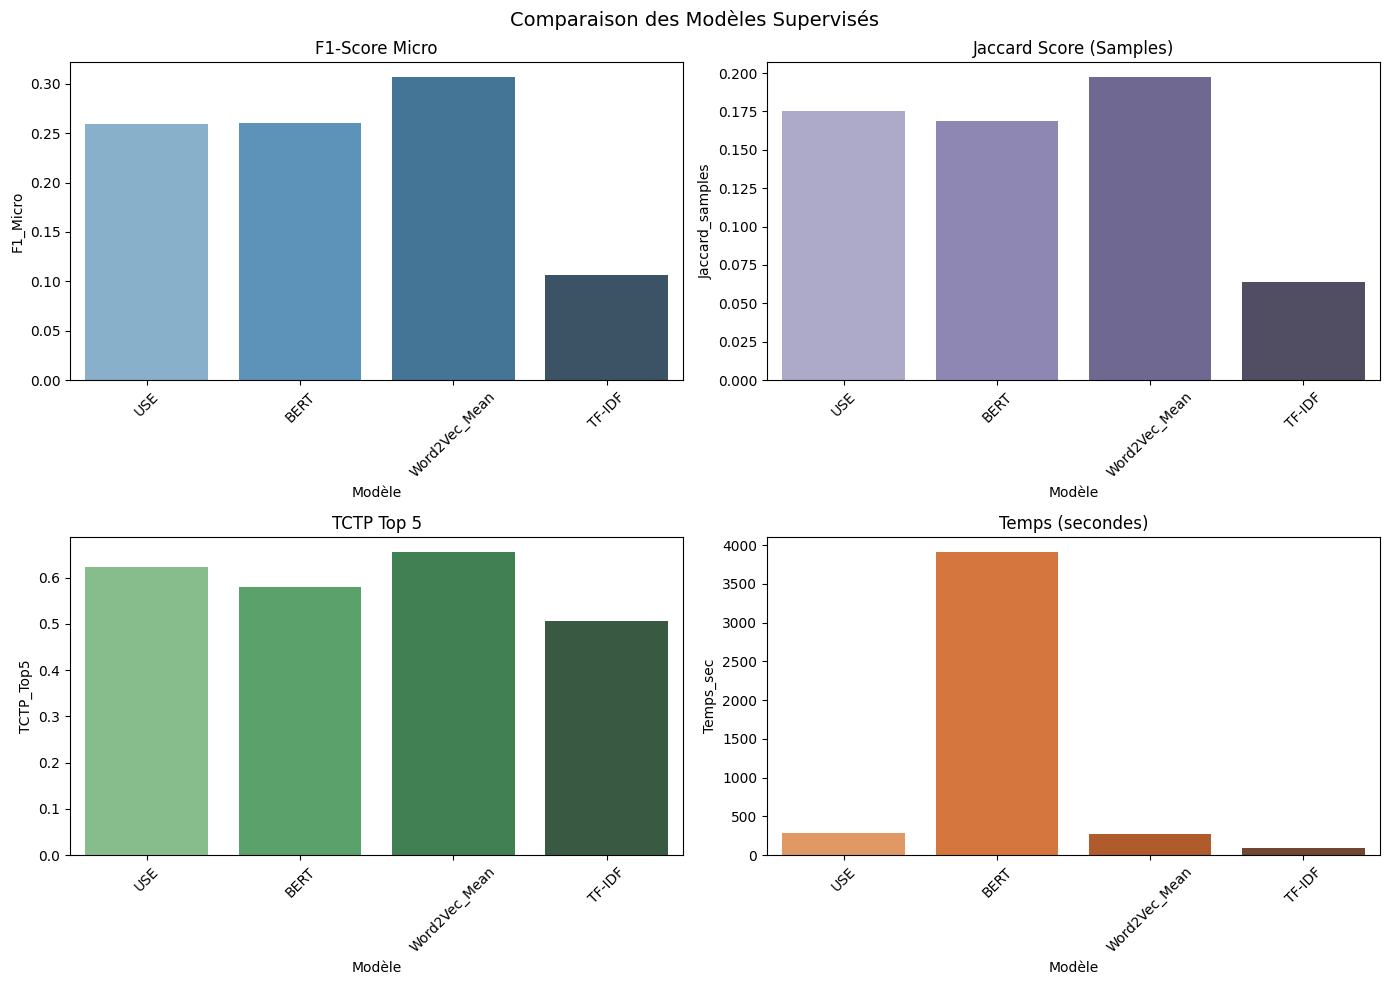

In [40]:
# Visualisation
if 'df_results' in dir() and len(df_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    sns.barplot(x='Modèle', y='F1_Micro', data=df_results, ax=axes[0, 0], palette='Blues_d')
    axes[0, 0].set_title('F1-Score Micro')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    sns.barplot(x='Modèle', y='Jaccard_samples', data=df_results, ax=axes[0, 1], palette='Purples_d')
    axes[0, 1].set_title('Jaccard Score (Samples)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    sns.barplot(x='Modèle', y='TCTP_Top5', data=df_results, ax=axes[1, 0], palette='Greens_d')
    axes[1, 0].set_title('TCTP Top 5')
    axes[1, 0].tick_params(axis='x', rotation=45)
        
    sns.barplot(x='Modèle', y='Temps_sec', data=df_results, ax=axes[1, 1], palette='Oranges_d')
    axes[1, 1].set_title('Temps (secondes)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.suptitle('Comparaison des Modèles Supervisés', fontsize=14)
    plt.tight_layout()
    plt.savefig('comparaison_modeles.png', dpi=150)
    plt.show()

## Conclusion

### Résultats :
- **Word2Vec** : Meilleur F1 (~0.31) et TCTP (~0.65)
- **USE** : Bon TCTP (~0.62) mais F1 moyen (~0.26)
- **BERT** : Performances similaires à USE
- **TF-IDF** : Baseline avec F1 plus faible (~0.11)

### Choix du modèle retenu : Word2Vec
- Meilleur compromis performance/temps
- Plus léger pour le déploiement API